# Named Entity Recognition

[Named Enity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) is one of the most common [NLP](https://en.wikipedia.org/wiki/Natural-language_processing) problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc.
*What can you use it for?* Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining! 

### Predicting named entities of GMB(Groningen Meaning Bank) corpus

In this notebook we will perform a Sequence Tagging with a Bi-directional LSTM Neural Network to extract the named entities from the annotated corpus.

<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/ner-image.png" width="800" height="800" align="center"/>

Entity tags are encoded using a BIO annotation scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The prefixes are used to detect multiword entities, e.g. sentence:"World War II", tags:(B-eve, I-eve, I-eve). All other words, which don’t refer to entities of interest, are labeled with the O tag.

Tag | Label meaning | Example Given
------------ | ------------- | 
geo | Geographical Entity | London
org | Organization | ONU
per | Person | Bush
gpe | Geopolitical Entity | British
tim | Time indicator | Wednesday
art | Artifact | Chrysler
eve | Event | Christmas
nat | Natural Phenomenon | Hurricane
O | No-Label | the

We will:
- Preprocess text data for NLP
- Build and train a Bi-directional LSTM model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own sentences!

#### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome named entity recognition task.*

Now, let's get started! 🚀

### Initial Setup
Let's start by importing some packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

print("Tensorflow version: ", tf.__version__)
print("GPU detected:", tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.3.1
GPU detected: []


## Training Parameters
We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 50  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 50
    EMBEDDING = 100

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Data

The movie ner dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

Let's take a look at data.

In [3]:
data = pd.read_csv("../data/biluo_ner_dataset.csv", encoding="latin1", names=['Sentence #', 'Word', 'Tag'])
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

Number of sentences:  47960
Number of words in the dataset:  35175
Tags: ['L-art', 'I-nat', 'B-per', 'I-eve', 'L-nat', 'Tag', 'B-tim', 'U-per', 'I-tim', 'L-gpe', 'U-org', 'L-org', 'L-tim', 'U-geo', 'B-nat', 'I-gpe', 'B-eve', 'B-geo', 'L-eve', 'I-geo', 'U-eve', 'U-gpe', 'L-per', 'U-nat', 'U-art', 'B-org', 'B-gpe', 'I-art', 'I-org', 'L-geo', 'I-per', 'U-tim', 'O', 'B-art']
Number of Labels:  34
What the dataset looks like:


,Sentence #,Word,Tag
0,Sentence #,Word,Tag
1,Sentence:0,Thousands,O
2,Sentence:0,of,O
3,Sentence:0,demonstrators,O
4,Sentence:0,have,O
5,Sentence:0,marched,O
6,Sentence:0,through,O
7,Sentence:0,London,U-geo
8,Sentence:0,to,O
9,Sentence:0,protest,O


In [4]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'U-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'U-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'U-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

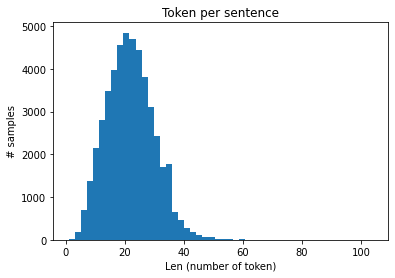

In [5]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the text.

- We will use the `word2idx` dictionary to convert each word to a corresponding integer ID and the `tag2idx` to do the same for the labels. Representing words as integers saves a lot of memory!
- In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the `sequence.pad_sequences()` method and `MAX_LEN` variable. All texts longer than `MAX_LEN` are truncated and shorter texts are padded to get them to the same length.

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter.

In [6]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

#print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
#print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[1]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[1]]))
print('After processing, sample:', X[1])
print('After processing, labels:', y[1])

Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O U-geo O O O O O U-geo O O O O O U-gpe O O O O O
After processing, sample: [13700 28984  5457 32927 15983 25605 28503  2054 25725 20618 24774 16157
  5195  5456 21033 20618 33261 28984  7946 21059 21882  2466 27301 31550
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
After processing, labels: [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Model

We will implement a Bidirectional Lstm Neural Network

In [7]:
input_word = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, input_length=MAX_LEN)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags+1, activation='softmax'))(model)
model = Model(input_word, out)

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 100)           3517700   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 35)            7035      
Total params: 3,685,535
Trainable params: 3,685,535
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluate

The Training is defined at the beginning by the type of instance on which runs:

- On CPU machine: 25 minutes for 5 epochs.
- On GPU machine: 5 minute for 5 epochs.

*Note*: Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict '**O**' or '**PAD**' without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the **precision**, **recall** and **f1-score** for each of the Tags.

In [8]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=1)

Epoch 1/5
1214/1214 [==============================] - 130s 107ms/step - loss: 0.2107 - accuracy: 0.9526 - val_loss: 0.0691 - val_accuracy: 0.9808
Epoch 2/5
1214/1214 [==============================] - 134s 110ms/step - loss: 0.0509 - accuracy: 0.9852 - val_loss: 0.0530 - val_accuracy: 0.9846
Epoch 3/5
1214/1214 [==============================] - 134s 111ms/step - loss: 0.0372 - accuracy: 0.9887 - val_loss: 0.0509 - val_accuracy: 0.9848
Epoch 4/5
1214/1214 [==============================] - 134s 110ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0517 - val_accuracy: 0.9850
Epoch 5/5
1214/1214 [==============================] - 130s 107ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0547 - val_accuracy: 0.9849


In [9]:
model.evaluate(X_te, np.array(y_te))

150/150 [==============================] - 3s 22ms/step - loss: 0.0528 - accuracy: 0.9853


[0.05280356854200363, 0.9853377938270569]

Evaluate some samples in the test set. (At each execution it will test on a different sample).

In [11]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1802 of 4796 (Test Set)
Word           ||True ||Pred
A              : O     O
White          : B-org B-org
House          : L-org L-org
spokesman      : O     O
,              : O     O
in             : O     O
a              : O     O
statement      : O     O
,              : O     O
said           : O     O
the            : O     O
referendum     : O     O
represents     : O     O
an             : O     O
important      : O     O
step           : O     O
in             : O     O
the            : O     O
democratic     : O     O
process        : O     O
in             : O     O
the            : O     O
Democratic     : B-geo B-geo
Republic       : L-geo I-geo
of             : O     I-geo
Congo          : U-geo L-geo
.              : O     O


## Save model and dictionaries

In [12]:
import pickle

# Saving Vocab
with open('../models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('../models/index_to_tag.pickle', 'wb') as handle:
    pickle.dump(idx2tag, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save('../models/bilstm.h5')

## Load model and dictionaries

In [14]:
import pickle

# Saving Vocab
with open('../models/word_to_index.pickle', 'rb') as handle:
    word2idx = pickle.load(handle)
 
# Saving Vocab
with open('../models/index_to_tag.pickle', 'rb') as handle:
    idx2tag = pickle.load(handle)
    
# Saving Model Weight
model = load_model('../models/bilstm.h5')

## It's your turn

Test out the model you just trained. Run the code Cell below and type your reviews in the widget, Have fun!🎉

Here are some inspirations:

- Obama was the president of USA.
- The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906
- Next Monday is Christmas!

Can you do better? Play around with the model hyperparameters!

In [15]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

layout = widgets.Layout(width='auto', height='100px') #set width and height

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here', layout=layout));

interactive(children=(Textarea(value='', description='sentence', layout=Layout(height='100px', width='auto'), …